In [253]:
import numpy
from src.data.datamanager import DataManager
from src.data.window import WindowSequence, KerasSequence
from src.data.dataset import MotionSense, Activity
from src.visual.plotter import Plotter, VecData
from src.network.gan import Gan, SimpleGan, SmoothingType, CGan, AdversarialAutoencoder, VaeGan
from src.network.generator import SimpleMlpGen
from src.network.discriminator import SimpleMlpDisc
from keras.optimizers import SGD, Adam, RMSprop
from pathlib import Path
import toml
datasets = toml.load("config.toml")["dataset"]
WISDM_PATH = Path(datasets["wisdm"])
MOTION_SENSE_PATH = Path(datasets["motion-sense"])
dataset = MotionSense(MOTION_SENSE_PATH)
datamanager = DataManager(dataset)
all_data=datamanager.read()
windows = datamanager.create_windows(set(Activity), 100, shuffle=True, seed=1, columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm'])#, bypass_raw="6a3bf91cfb")
# windows = datamanager.create_windows(set(Activity), 100, shuffle=False, seed=1, columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm', "activity"])#, bypass_raw="6a3bf91cfb")

In [355]:
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def confusion(y_pred, y_true, classes, title=None):
    data = confusion_matrix(y_true, y_pred, labels=[i for i in range(len(classes))], normalize="pred")
    data = data*100
    
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(9, 6))
    h = sns.heatmap(data, annot=True, fmt=".1f", linewidths=.5, ax=ax)
    h.set(xticklabels=classes, yticklabels=classes, xlabel="Non-truth", ylabel="Truth")
    if title:
        h.set(title=title)
    
    

#     data = data / data.sum(axis=1)[:, numpy.newaxis]
#     fig = px.imshow(
#         data,
#         labels=dict(x="Truth", y="Predicted", color="Items"),
#         x=sorted(dataset.ACTIVITIES.values()),
#         y=sorted(dataset.ACTIVITIES.values()))
#     fig.update_xaxes(side="top")
#     fig.show()

# Preparing Data

In [223]:
X = []
Y = []
Y_onehot = []
for x, y in windows.to_keras_sequence(1):
    x = x.squeeze(axis=0)
    y = y.squeeze(axis=0)
    Y_onehot.append(y)
    X.append(x)
    Y.append(y.argmax())
X = numpy.asarray(X)
Y = numpy.asarray(Y)
Y_onehot = numpy.asarray(Y_onehot)

boundary = round(len(X)*(70/100))
X_train, X_test = X[:boundary], X[boundary:]
Y_train, Y_test = Y[:boundary], Y[boundary:]
Y_train_onehot, Y_test_onehot = Y_onehot[:boundary], Y_onehot[boundary:]

s = X_train.shape
X_train_flat, X_test_flat = X_train.reshape(-1, s[-1] * s[-2]), X_test.reshape(-1, s[-1] * s[-2])

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")
print(f"Y_train_onehot: {Y_train_onehot.shape}, Y_test_onehot: {Y_test_onehot.shape}")
print(f"X_train_flat: {X_train_flat.shape}, X_test_flat: {X_test_flat.shape}")

X_train: (9514, 100, 6), X_test: (4078, 100, 6)
Y_train: (9514,), Y_test: (4078,)
Y_train_onehot: (9514, 6), Y_test_onehot: (4078, 6)
X_train_flat: (9514, 600), X_test_flat: (4078, 600)


# KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier

knn_1 = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn_3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_5 = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_21 = KNeighborsClassifier(n_neighbors=21, n_jobs=-1)
knn_99 = KNeighborsClassifier(n_neighbors=99, n_jobs=-1)


print("Started 1")
knn_1.fit(X_train_flat, Y_train)
print("Started 3")
knn_3.fit(X_train_flat, Y_train)
print("Started 5")
knn_5.fit(X_train_flat, Y_train)
print("Started 21")
knn_21.fit(X_train_flat, Y_train)
print("Started 99")
knn_99.fit(X_train_flat, Y_train)
print("Done")

Started 1
Started 3
Started 5
Started 21
Started 99
Done


In [62]:
print(f"knn_1: {knn_1.score(X_test_flat, Y_test):.1%}")
print(f"knn_3: {knn_3.score(X_test_flat, Y_test):.1%}")
print(f"knn_5: {knn_5.score(X_test_flat, Y_test):.1%}")
print(f"knn_21: {knn_21.score(X_test_flat, Y_test):.1%}")
                print(f"knn_99: {knn_99.score(X_test_flat, Y_test):.1%}%")

knn_1: 89.4%
knn_3: 87.8%
knn_5: 86.2%
knn_21: 76.0%
knn_99: 57.4%


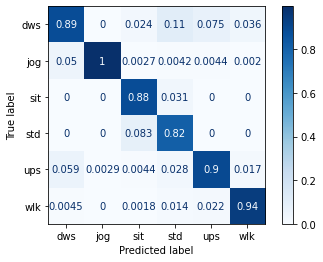

In [167]:
y_pred = knn_1.predict(X_test_flat)
conf = confusion_matrix(Y_test, y_pred, labels=[i for i in range(windows.num_classes)], normalize="pred")
print(conf)

In [174]:
y_score = knn_1.predict_proba(X_test_flat)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(knn_1, X_test_flat, Y_test,
                                 display_labels=sorted(dataset.ACTIVITIES.values()),
                                 cmap=plt.cm.Blues,
                            normalize="pred")
plt.show()
# confusion(y_pred, Y_test, windows.num_classes)

In [169]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

Precision: 0.9047982726273632, Recall: 0.8571205900364474, Fscore: 0.8711006584267099


In [176]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test, y_score, multi_class="ovr")
print(f"Roc Auc Score: {auc::.1%}")

Roc Auc Score: 0.92


# Radius Nearest Neighbors

In [91]:
from sklearn.neighbors import RadiusNeighborsClassifier

rnn_05 = RadiusNeighborsClassifier(radius=0.01, n_jobs=-1, outlier_label="most_frequent")
rnn_1 = RadiusNeighborsClassifier(radius=0.05, n_jobs=-1, outlier_label="most_frequent")
rnn_2 = RadiusNeighborsClassifier(radius=0.1, n_jobs=-1, outlier_label="most_frequent")
rnn_3 = RadiusNeighborsClassifier(radius=0.5, n_jobs=-1, outlier_label="most_frequent")

print("Started 05")
rnn_05.fit(X_train_flat, Y_train)
print("Started 1")
rnn_1.fit(X_train_flat, Y_train)
print("Started 2")
rnn_2.fit(X_train_flat, Y_train)
print("Started 3")
rnn_3.fit(X_train_flat, Y_train)
print("Done")

Started 05
Started 1
Started 2
Started 3
Done


In [92]:
print(f"rnn_05: {rnn_05.score(X_test_flat, Y_test)*100:2.1f}%")
print(f"rnn_1: {rnn_1.score(X_test_flat, Y_test)*100:2.1f}%")
print(f"rnn_2: {rnn_2.score(X_test_flat, Y_test)*100:2.1f}%")
print(f"rnn_3: {rnn_3.score(X_test_flat, Y_test)*100:2.1f}%")

rnn_05: 39.9%
rnn_1: 51.3%
rnn_2: 48.8%
rnn_3: 49.6%


# SVM

In [179]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()


parameters = {'kernel':('linear', 'rbf'), 'C':range(1, 10)}
best_svc = GridSearchCV(svc, parameters, n_jobs=-1, verbose=3)

best_svc.fit(X_train_flat, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/joblib/numpy_pickle.py:103: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 22.8min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': range(1, 10), 'kernel': ('linear', 'rbf')},
             verbose=3)

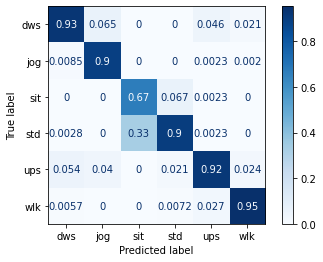

In [181]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(best_svc, X_test_flat, Y_test,
                                 display_labels=sorted(dataset.ACTIVITIES.values()),
                                 cmap=plt.cm.Blues,
                            normalize="pred")
plt.show()
# confusion(y_pred, Y_test, windows.num_classes)

In [185]:
y_pred = best_svc.predict(X_test_flat)

AttributeError: predict_proba is not available when  probability=False

In [186]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

Precision: 0.8787294929574688, Recall: 0.8432502667169596, Fscore: 0.8416016495810958


In [192]:
print(f"best_svc Accuracy: {best_svc.score(X_test_flat, Y_test):.1%}")

best_svc Accuracy: 83.3%


# Categorical Naive Bayes

In [89]:
from sklearn.naive_bayes import CategoricalNB

cnb_0 = CategoricalNB(alpha=0.0)
cnb_01 = CategoricalNB(alpha=0.1)
cnb_05 = CategoricalNB(alpha=0.5)
cnb_1 = CategoricalNB(alpha=1.)

print("Started cnb_0")
cnb_0.fit(X_train_flat, Y_train)
print("Started cnb_01")
cnb_01.fit(X_train_flat, Y_train)
print("Started cnb_05")
cnb_05.fit(X_train_flat, Y_train)
print("Started cnb_1")
cnb_1.fit(X_train_flat, Y_train)
print("Done")

Started cnb_0


/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Started cnb_01
Started cnb_05
Started cnb_1
Done


In [90]:
print(f"cnb_0: {cnb_0.score(X_test_flat, Y_test)*100:2.1f}%")
print(f"cnb_01: {cnb_01.score(X_test_flat, Y_test)*100:2.2f}%")
print(f"cnb_05: {cnb_05.score(X_test_flat, Y_test)*100:2.2f}%")
print(f"cnb_1: {cnb_1.score(X_test_flat, Y_test)*100:2.2f}%")

cnb_0: 23.3%
cnb_01: 23.27%
cnb_05: 23.27%
cnb_1: 23.27%


# Decision Tree

In [191]:
from sklearn.tree import DecisionTreeClassifier

tree_para = {'criterion':['gini','entropy'], "max_features":["auto", None], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
tree = GridSearchCV(DecisionTreeClassifier(), tree_para, verbose=100, n_jobs=-1)
tree.fit(X_train_flat, Y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/joblib/numpy_pickle.py:103: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  2.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  6.1min
[Paralle

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'max_features': ['auto', None]},
             verbose=100)

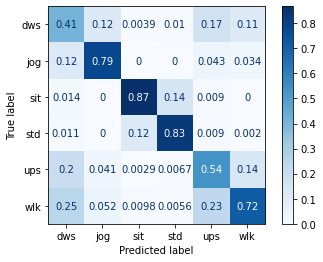

In [193]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(tree, X_test_flat, Y_test,
                                 display_labels=sorted(dataset.ACTIVITIES.values()),
                                 cmap=plt.cm.Blues,
                            normalize="pred")
plt.show()

In [194]:
print(f"Decision Tree Accuracy: {tree.score(X_test_flat, Y_test):.1%}%")

Decision Tree Accuracy: 73.91%


In [198]:
y_pred = tree.predict(X_test_flat)

In [200]:
y_score = tree.predict_proba(X_test_flat)

In [201]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

Precision: 0.6919560754272688, Recall: 0.6842800181803287, Fscore: 0.6876637835526745


In [202]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test, y_score, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

Roc Auc Score: 0.82


# MLP

In [205]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train_flat, Y_train)

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(max_iter=300, random_state=1)

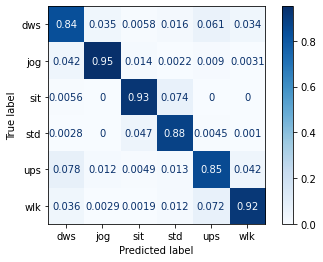

In [206]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(mlp, X_test_flat, Y_test,
                                 display_labels=sorted(dataset.ACTIVITIES.values()),
                                 cmap=plt.cm.Blues,
                            normalize="pred")
plt.show()

In [220]:
print(f"MLP accuarcy: {mlp.score(X_test_flat, Y_test):.1%}")

MLP accuarcy: 90.1%


In [212]:
y_pred = mlp.predict(X_test_flat)

In [213]:
y_score = mlp.predict_proba(X_test_flat)

In [217]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

Precision: 89.5%, Recall: 88.0%, Fscore: 89%


In [219]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test, y_score, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

Roc Auc Score: 98.0%


# LSTM

## LSTM 1

In [271]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax

lstm_1 = Sequential()
lstm_1.add(LSTM(units=100, input_shape=(X_train.shape[1:])))
lstm_1.add(Dropout(0.2))
lstm_1.add(Dense(100, activation="relu"))
lstm_1.add(Dropout(0.2))
lstm_1.add(Dense(windows.num_classes, activation="softmax"))
lstm_1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=["categorical_accuracy"]
)
lstm_1.fit(X_train, Y_train_onehot, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 18s - loss: 1.6544 - categorical_accuracy: 0.2876
Epoch 2/30
 - 20s - loss: 1.1337 - categorical_accuracy: 0.4817
Epoch 3/30
 - 21s - loss: 1.0023 - categorical_accuracy: 0.5164
Epoch 4/30
 - 20s - loss: 0.8887 - categorical_accuracy: 0.5645
Epoch 5/30
 - 22s - loss: 0.8079 - categorical_accuracy: 0.5906
Epoch 6/30
 - 19s - loss: 0.7431 - categorical_accuracy: 0.6103
Epoch 7/30
 - 20s - loss: 0.7511 - categorical_accuracy: 0.6073
Epoch 8/30
 - 19s - loss: 0.7026 - categorical_accuracy: 0.6284
Epoch 9/30
 - 18s - loss: 0.6587 - categorical_accuracy: 0.6501
Epoch 10/30
 - 19s - loss: 0.6181 - categorical_accuracy: 0.6894
Epoch 11/30
 - 19s - loss: 0.5611 - categorical_accuracy: 0.7205
Epoch 12/30
 - 20s - loss: 0.5234 - categorical_accuracy: 0.7358
Epoch 13/30
 - 21s - loss: 0.4995 - categorical_accuracy: 0.7417
Epoch 14/30
 - 19s - loss: 0.4731 - categorical_accuracy: 0.7615
Epoch 15/30
 - 18s - loss: 0.4500 - categorical_accuracy: 0.7821
Epoch 16/30
 - 18s - loss: 0.4485 

In [322]:
f"LSTM_1 Accuracy: {lstm_1.evaluate(X_test, Y_test_onehot)[1]:.1%}"

4078/4078 [==============================] - 2s 552us/step


'LSTM_1 Accuracy: 81.0%'

## LSTM 2 (Success)

In [280]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax

lstm_2 = Sequential()
lstm_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
lstm_2.add(Dropout(0.1))
lstm_2.add(LSTM(units=50))
lstm_2.add(Dropout(0.1))
lstm_2.add(Dense(100, activation="relu"))
lstm_2.add(Dropout(0.2))
lstm_2.add(Dense(windows.num_classes, activation="softmax"))
lstm_2.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=["categorical_accuracy"]
)
lstm_2.fit(X_train, Y_train_onehot, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 25s - loss: 1.4792 - categorical_accuracy: 0.3699
Epoch 2/30
 - 40s - loss: 1.0102 - categorical_accuracy: 0.5083
Epoch 3/30
 - 28s - loss: 0.8280 - categorical_accuracy: 0.6018
Epoch 4/30
 - 23s - loss: 0.7913 - categorical_accuracy: 0.6147
Epoch 5/30
 - 24s - loss: 0.7565 - categorical_accuracy: 0.6335
Epoch 6/30
 - 26s - loss: 0.6807 - categorical_accuracy: 0.6645
Epoch 7/30
 - 24s - loss: 0.6665 - categorical_accuracy: 0.6721
Epoch 8/30
 - 24s - loss: 0.6025 - categorical_accuracy: 0.7084
Epoch 9/30
 - 24s - loss: 0.5664 - categorical_accuracy: 0.7313
Epoch 10/30
 - 25s - loss: 0.5380 - categorical_accuracy: 0.7571
Epoch 11/30
 - 24s - loss: 0.5032 - categorical_accuracy: 0.7797
Epoch 12/30
 - 25s - loss: 0.4602 - categorical_accuracy: 0.8074
Epoch 13/30
 - 26s - loss: 0.4304 - categorical_accuracy: 0.8286
Epoch 14/30
 - 23s - loss: 0.3975 - categorical_accuracy: 0.8491
Epoch 15/30
 - 23s - loss: 0.3871 - categorical_accuracy: 0.8562
Epoch 16/30
 - 23s - loss: 0.3675 

In [323]:
f"LSTM_2 Accuracy: {lstm_2.evaluate(X_test, Y_test_onehot)[1]:.1%}"

4078/4078 [==============================] - 3s 692us/step


'LSTM_2 Accuracy: 91.3%'

In [363]:
y_pred_onehot = lstm_2.predict(X_test)
y_pred = y_pred_onehot.argmax(axis=1)

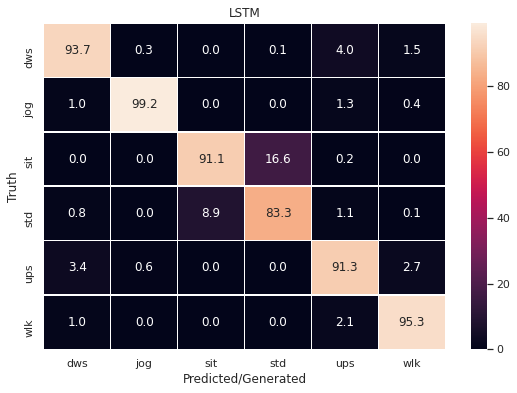

In [364]:
confusion(y_pred, Y_test, sorted(dataset.ACTIVITIES.values()), "LSTM")

In [318]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

Precision: 92.3%, Recall: 91.8%, Fscore: 92.0%


In [319]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test_onehot, y_pred_onehot, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

Roc Auc Score: 99.1%


## LSTM 3

In [283]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax

lstm_3 = Sequential()
lstm_3.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1:])))
lstm_3.add(Dropout(0.2))
lstm_3.add(LSTM(units=70))
lstm_3.add(Dropout(0.2))
lstm_3.add(Dense(100, activation="relu"))
lstm_3.add(Dropout(0.2))
lstm_3.add(Dense(windows.num_classes, activation="softmax"))
lstm_3.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=["categorical_accuracy"]
)
lstm_3.fit(X_train, Y_train_onehot, epochs=40, batch_size=32, verbose=2)

Epoch 1/40
 - 29s - loss: 1.6948 - categorical_accuracy: 0.2684
Epoch 2/40
 - 26s - loss: 1.6635 - categorical_accuracy: 0.2752
Epoch 3/40
 - 27s - loss: 1.6363 - categorical_accuracy: 0.3037
Epoch 4/40
 - 26s - loss: 1.5631 - categorical_accuracy: 0.3278
Epoch 5/40
 - 28s - loss: 1.4481 - categorical_accuracy: 0.3439
Epoch 6/40
 - 27s - loss: 1.4919 - categorical_accuracy: 0.3286
Epoch 7/40
 - 26s - loss: 1.1284 - categorical_accuracy: 0.4675
Epoch 8/40
 - 26s - loss: 1.1299 - categorical_accuracy: 0.4541
Epoch 9/40
 - 26s - loss: 1.0120 - categorical_accuracy: 0.4983
Epoch 10/40
 - 26s - loss: 0.8866 - categorical_accuracy: 0.5761
Epoch 11/40
 - 26s - loss: 0.7853 - categorical_accuracy: 0.6283
Epoch 12/40
 - 26s - loss: 0.6993 - categorical_accuracy: 0.6661
Epoch 13/40
 - 27s - loss: 0.5774 - categorical_accuracy: 0.7163
Epoch 14/40
 - 26s - loss: 0.5325 - categorical_accuracy: 0.7487
Epoch 15/40
 - 26s - loss: 0.4839 - categorical_accuracy: 0.7742
Epoch 16/40
 - 27s - loss: 0.4585 

In [324]:
f"LSTM_3 Accuracy: {lstm_3.evaluate(X_test, Y_test_onehot)[1]:.1%}"

4078/4078 [==============================] - 3s 724us/step


'LSTM_3 Accuracy: 82.6%'

# 1D CNN

## CNN 1

In [331]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax, Conv1D, MaxPooling1D, Flatten

cnn_1 = Sequential()
cnn_1.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1:])))
cnn_1.add(MaxPooling1D(pool_size=2))
cnn_1.add(Flatten())
cnn_1.add(Dropout(0.2))
cnn_1.add(Dense(100, activation="relu"))
cnn_1.add(Dropout(0.2))
cnn_1.add(Dense(windows.num_classes, activation="softmax"))
cnn_1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=["categorical_accuracy"]
)
cnn_1.fit(X_train, Y_train_onehot, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
9514/9514 [==============================] - 5s 563us/step - loss: 0.9185 - categorical_accuracy: 0.5864
Epoch 2/30
9514/9514 [==============================] - 3s 266us/step - loss: 0.5613 - categorical_accuracy: 0.7583
Epoch 3/30
9514/9514 [==============================] - 2s 248us/step - loss: 0.4853 - categorical_accuracy: 0.8034
Epoch 4/30
9514/9514 [==============================] - 2s 232us/step - loss: 0.4435 - categorical_accuracy: 0.8223
Epoch 5/30
9514/9514 [==============================] - 3s 280us/step - loss: 0.4139 - categorical_accuracy: 0.8387
Epoch 6/30
9514/9514 [==============================] - 3s 301us/step - loss: 0.3872 - categorical_accuracy: 0.8476
Epoch 7/30
9514/9514 [==============================] - 3s 266us/step - loss: 0.3602 - categorical_accuracy: 0.8630
Epoch 8/30
9514/9514 [==============================] - 4s 393us/step - loss: 0.3282 - categorical_accuracy: 0.8772
Epoch 9/30
9514/9514 [==============================] - 3s 366us/step - 

In [394]:
print(f"CNN_1 Accuracy: {cnn_1.evaluate(X_test, Y_test_onehot)[1]:.1%}")

y_pred_onehot = cnn_1.predict(X_test)
y_pred = y_pred_onehot.argmax(axis=1)

from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test_onehot, y_pred_onehot, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

4078/4078 [==============================] - 0s 62us/step
CNN_1 Accuracy: 93.9%
Precision: 93.9%, Recall: 93.1%, Fscore: 93.4%
Roc Auc Score: 99.3%


## CNN 2

In [339]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax, Conv1D, MaxPooling1D, Flatten

cnn_2 = Sequential()
cnn_2.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1:])))
cnn.add(Dropout(0.2))
cnn_2.add(MaxPooling1D(pool_size=2))
# cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# cnn.add(Dropout(0.2))
# cnn.add(MaxPooling1D(pool_size=2))
cnn_2.add(Flatten())
cnn_2.add(Dropout(0.3))
cnn_2.add(Dense(100, activation="relu"))
cnn_2.add(Dropout(0.2))
cnn_2.add(Dense(windows.num_classes, activation="softmax"))
cnn_2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=["categorical_accuracy"]
)
cnn_2.fit(X_train, Y_train_onehot, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
9514/9514 [==============================] - 3s 367us/step - loss: 0.9410 - categorical_accuracy: 0.5920
Epoch 2/30
9514/9514 [==============================] - 3s 309us/step - loss: 0.5531 - categorical_accuracy: 0.7609
Epoch 3/30
9514/9514 [==============================] - 3s 271us/step - loss: 0.4794 - categorical_accuracy: 0.8092
Epoch 4/30
9514/9514 [==============================] - 3s 296us/step - loss: 0.4315 - categorical_accuracy: 0.8305
Epoch 5/30
9514/9514 [==============================] - 2s 231us/step - loss: 0.3932 - categorical_accuracy: 0.8459
Epoch 6/30
9514/9514 [==============================] - 3s 266us/step - loss: 0.3679 - categorical_accuracy: 0.8621
Epoch 7/30
9514/9514 [==============================] - 2s 254us/step - loss: 0.3415 - categorical_accuracy: 0.8690
Epoch 8/30
9514/9514 [==============================] - 2s 255us/step - loss: 0.3185 - categorical_accuracy: 0.8820
Epoch 9/30
9514/9514 [==============================] - 3s 304us/step - 

In [391]:
print(f"CNN_2 Accuracy: {cnn_2.evaluate(X_test, Y_test_onehot)[1]:.1%}")

y_pred_onehot = cnn_2.predict(X_test)
y_pred = y_pred_onehot.argmax(axis=1)

from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test_onehot, y_pred_onehot, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

4078/4078 [==============================] - 0s 54us/step
CNN_2 Accuracy: 93.2%
Precision: 93.3%, Recall: 92.4%, Fscore: 92.8%
Roc Auc Score: 99.4%


## CNN 3 (Slightly Better)

In [350]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax, Conv1D, MaxPooling1D, Flatten

cnn_3 = Sequential()
cnn_3.add(Conv1D(filters=42, kernel_size=3, activation='relu', input_shape=(X_train.shape[1:])))
cnn_3.add(Dropout(0.3))
cnn_3.add(MaxPooling1D(pool_size=2))
cnn_3.add(Flatten())
cnn_3.add(Dropout(0.4))
cnn_3.add(Dense(120, activation="relu"))
cnn_3.add(Dropout(0.3))
cnn_3.add(Dense(windows.num_classes, activation="softmax"))
cnn_3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=["categorical_accuracy"]
)
cnn_3.fit(X_train, Y_train_onehot, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 2s - loss: 0.9203 - categorical_accuracy: 0.5791
Epoch 2/30
 - 2s - loss: 0.5841 - categorical_accuracy: 0.7352
Epoch 3/30
 - 2s - loss: 0.5037 - categorical_accuracy: 0.7882
Epoch 4/30
 - 2s - loss: 0.4571 - categorical_accuracy: 0.8079
Epoch 5/30
 - 2s - loss: 0.4230 - categorical_accuracy: 0.8300
Epoch 6/30
 - 2s - loss: 0.3914 - categorical_accuracy: 0.8406
Epoch 7/30
 - 2s - loss: 0.3644 - categorical_accuracy: 0.8602
Epoch 8/30
 - 2s - loss: 0.3447 - categorical_accuracy: 0.8678
Epoch 9/30
 - 2s - loss: 0.3206 - categorical_accuracy: 0.8748
Epoch 10/30
 - 2s - loss: 0.3028 - categorical_accuracy: 0.8863
Epoch 11/30
 - 2s - loss: 0.2822 - categorical_accuracy: 0.8947
Epoch 12/30
 - 2s - loss: 0.2634 - categorical_accuracy: 0.9028
Epoch 13/30
 - 2s - loss: 0.2453 - categorical_accuracy: 0.9081
Epoch 14/30
 - 2s - loss: 0.2219 - categorical_accuracy: 0.9217
Epoch 15/30
 - 2s - loss: 0.2193 - categorical_accuracy: 0.9191
Epoch 16/30
 - 2s - loss: 0.2124 - categorical_ac

In [390]:
print(f"CNN_3 Accuracy: {cnn_3.evaluate(X_test, Y_test_onehot)[1]:.1%}")

y_pred_onehot = cnn_3.predict(X_test)
y_pred = y_pred_onehot.argmax(axis=1)

from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_test, y_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test_onehot, y_pred_onehot, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

4078/4078 [==============================] - 0s 59us/step
CNN_3 Accuracy: 94.1%
Precision: 94.3%, Recall: 93.6%, Fscore: 94.0%
Roc Auc Score: 99.4%


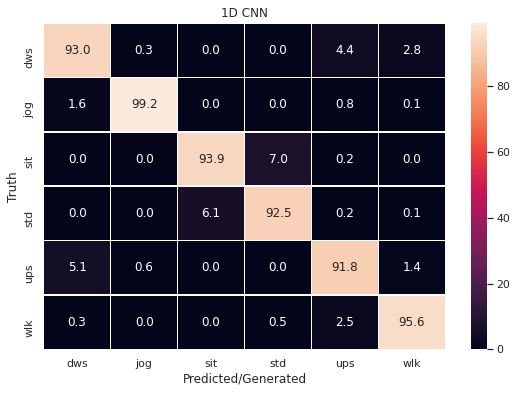

In [362]:
confusion(y_pred, Y_test, sorted(dataset.ACTIVITIES.values()), "1D CNN")

# 1D CNN with Shorter and Longer Window

## Shorter

In [365]:
windows_short = datamanager.create_windows(set(Activity), 50, shuffle=True, seed=1, columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm'])

In [366]:
X_s = []
Y_s = []
Y_s_onehot = []
for x, y in windows_short.to_keras_sequence(1):
    x = x.squeeze(axis=0)
    y = y.squeeze(axis=0)
    Y_s_onehot.append(y)
    X_s.append(x)
    Y_s.append(y.argmax())
X_s = numpy.asarray(X_s)
Y_s = numpy.asarray(Y_s)
Y_s_onehot = numpy.asarray(Y_s_onehot)

boundary = round(len(X_s)*(70/100))
X_s_train, X_s_test = X_s[:boundary], X_s[boundary:]
Y_s_train, Y_s_test = Y_s[:boundary], Y_s[boundary:]
Y_s_train_onehot, Y_s_test_onehot = Y_s_onehot[:boundary], Y_s_onehot[boundary:]

s = X_s_train.shape
X_s_train_flat, X_s_test_flat = X_s_train.reshape(-1, s[-1] * s[-2]), X_s_test.reshape(-1, s[-1] * s[-2])

print(f"X_s_train: {X_s_train.shape}, X_s_test: {X_s_test.shape}")
print(f"Y_s_train: {Y_s_train.shape}, Y_s_test: {Y_s_test.shape}")
print(f"Y_s_train_onehot: {Y_s_train_onehot.shape}, Y_s_test_onehot: {Y_s_test_onehot.shape}")
print(f"X_s_train_flat: {X_s_train_flat.shape}, X_s_test_flat: {X_s_test_flat.shape}")

X_s_train: (19404, 50, 6), X_s_test: (8316, 50, 6)
Y_s_train: (19404,), Y_s_test: (8316,)
Y_s_train_onehot: (19404, 6), Y_s_test_onehot: (8316, 6)
X_s_train_flat: (19404, 300), X_s_test_flat: (8316, 300)


In [367]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax, Conv1D, MaxPooling1D, Flatten

cnn_s_3 = Sequential()
cnn_s_3.add(Conv1D(filters=42, kernel_size=3, activation='relu', input_shape=(X_s_train.shape[1:])))
cnn_s_3.add(Dropout(0.2))
cnn_s_3.add(MaxPooling1D(pool_size=2))
# cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# cnn.add(Dropout(0.2))
# cnn.add(MaxPooling1D(pool_size=2))
cnn_s_3.add(Flatten())
cnn_s_3.add(Dropout(0.3))
cnn_s_3.add(Dense(120, activation="relu"))
cnn_s_3.add(Dropout(0.2))
cnn_s_3.add(Dense(windows.num_classes, activation="softmax"))
cnn_s_3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=["categorical_accuracy"]
)
cnn_s_3.fit(X_s_train, Y_s_train_onehot, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 3s - loss: 0.8140 - categorical_accuracy: 0.6347
Epoch 2/30
 - 2s - loss: 0.5580 - categorical_accuracy: 0.7689
Epoch 3/30
 - 2s - loss: 0.4901 - categorical_accuracy: 0.8042
Epoch 4/30
 - 2s - loss: 0.4407 - categorical_accuracy: 0.8302
Epoch 5/30
 - 2s - loss: 0.3980 - categorical_accuracy: 0.8490
Epoch 6/30
 - 2s - loss: 0.3608 - categorical_accuracy: 0.8682
Epoch 7/30
 - 2s - loss: 0.3504 - categorical_accuracy: 0.8714
Epoch 8/30
 - 2s - loss: 0.3198 - categorical_accuracy: 0.8854
Epoch 9/30
 - 2s - loss: 0.2971 - categorical_accuracy: 0.8958
Epoch 10/30
 - 2s - loss: 0.2814 - categorical_accuracy: 0.9000
Epoch 11/30
 - 2s - loss: 0.2616 - categorical_accuracy: 0.9088
Epoch 12/30
 - 2s - loss: 0.2556 - categorical_accuracy: 0.9127
Epoch 13/30
 - 2s - loss: 0.2408 - categorical_accuracy: 0.9171
Epoch 14/30
 - 2s - loss: 0.2284 - categorical_accuracy: 0.9217
Epoch 15/30
 - 2s - loss: 0.2163 - categorical_accuracy: 0.9234
Epoch 16/30
 - 2s - loss: 0.2129 - categorical_ac

In [392]:
print(f"CNN_S_3 Accuracy: {cnn_s_3.evaluate(X_s_test, Y_s_test_onehot)[1]:.1%}")

y_s_pred_onehot = cnn_s_3.predict(X_s_test)
y_s_pred = y_s_pred_onehot.argmax(axis=1)

from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_s_test, y_s_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_s_test_onehot, y_s_pred_onehot, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

8316/8316 [==============================] - 0s 39us/step
CNN_S_3 Accuracy: 94.1%
Precision: 94.7%, Recall: 93.7%, Fscore: 94.1%
Roc Auc Score: 99.5%


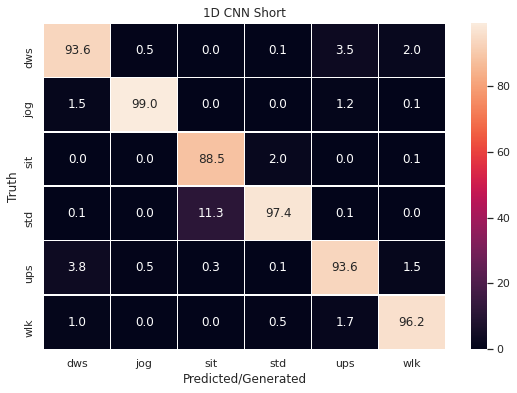

In [387]:
confusion(y_s_pred, Y_s_test, sorted(dataset.ACTIVITIES.values()), "1D CNN Short")

## Longer Window

In [370]:
windows_long = datamanager.create_windows(set(Activity), 250, shuffle=True, seed=1, columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm'])

In [373]:
X_l = []
Y_l = []
Y_l_onehot = []
for x, y in windows_long.to_keras_sequence(1):
    x = x.squeeze(axis=0)
    y = y.squeeze(axis=0)
    Y_l_onehot.append(y)
    X_l.append(x)
    Y_l.append(y.argmax())
X_l = numpy.asarray(X_l)
Y_l = numpy.asarray(Y_l)
Y_l_onehot = numpy.asarray(Y_l_onehot)

boundary = round(len(X_l)*(70/100))
X_l_train, X_l_test = X_l[:boundary], X_l[boundary:]
Y_l_train, Y_l_test = Y_l[:boundary], Y_l[boundary:]
Y_l_train_onehot, Y_l_test_onehot = Y_l_onehot[:boundary], Y_l_onehot[boundary:]

s = X_l_train.shape
X_l_train_flat, X_l_test_flat = X_l_train.reshape(-1, s[-1] * s[-2]), X_l_test.reshape(-1, s[-1] * s[-2])

print(f"X_l_train: {X_l_train.shape}, X_l_test: {X_l_test.shape}")
print(f"Y_l_train: {Y_l_train.shape}, Y_l_test: {Y_l_test.shape}")
print(f"Y_l_train_onehot: {Y_l_train_onehot.shape}, Y_l_test_onehot: {Y_l_test_onehot.shape}")
print(f"X_l_train_flat: {X_l_train_flat.shape}, X_l_test_flat: {X_l_test_flat.shape}")

X_l_train: (3571, 250, 6), X_l_test: (1531, 250, 6)
Y_l_train: (3571,), Y_l_test: (1531,)
Y_l_train_onehot: (3571, 6), Y_l_test_onehot: (1531, 6)
X_l_train_flat: (3571, 1500), X_l_test_flat: (1531, 1500)


In [385]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Softmax, Conv1D, MaxPooling1D, Flatten

cnn_l_3 = Sequential()
cnn_l_3.add(Conv1D(filters=42, kernel_size=3, activation='relu', input_shape=(X_l_train.shape[1:])))
cnn_l_3.add(Dropout(0.3))
cnn_l_3.add(MaxPooling1D(pool_size=2))
cnn_l_3.add(Flatten())
cnn_l_3.add(Dropout(0.4))
cnn_l_3.add(Dense(100, activation="relu"))
cnn_l_3.add(Dropout(0.3))
cnn_l_3.add(Dense(windows.num_classes, activation="softmax"))
cnn_l_3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=["categorical_accuracy"]
)
cnn_l_3.fit(X_l_train, Y_l_train_onehot, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 1s - loss: 1.1214 - categorical_accuracy: 0.5024
Epoch 2/30
 - 1s - loss: 0.6637 - categorical_accuracy: 0.6788
Epoch 3/30
 - 1s - loss: 0.5356 - categorical_accuracy: 0.7530
Epoch 4/30
 - 1s - loss: 0.4791 - categorical_accuracy: 0.7777
Epoch 5/30
 - 1s - loss: 0.4325 - categorical_accuracy: 0.8073
Epoch 6/30
 - 1s - loss: 0.4037 - categorical_accuracy: 0.8317
Epoch 7/30
 - 1s - loss: 0.3891 - categorical_accuracy: 0.8283
Epoch 8/30
 - 1s - loss: 0.3688 - categorical_accuracy: 0.8379
Epoch 9/30
 - 1s - loss: 0.3369 - categorical_accuracy: 0.8586
Epoch 10/30
 - 1s - loss: 0.3238 - categorical_accuracy: 0.8611
Epoch 11/30
 - 1s - loss: 0.2901 - categorical_accuracy: 0.8885
Epoch 12/30
 - 1s - loss: 0.2777 - categorical_accuracy: 0.8877
Epoch 13/30
 - 1s - loss: 0.2641 - categorical_accuracy: 0.8995
Epoch 14/30
 - 1s - loss: 0.2588 - categorical_accuracy: 0.9006
Epoch 15/30
 - 1s - loss: 0.2507 - categorical_accuracy: 0.8983
Epoch 16/30
 - 1s - loss: 0.2367 - categorical_ac

In [393]:
print(f"CNN_L_3 Accuracy: {cnn_l_3.evaluate(X_l_test, Y_l_test_onehot)[1]:.1%}")

y_l_pred_onehot = cnn_l_3.predict(X_l_test)
y_l_pred = y_l_pred_onehot.argmax(axis=1)

from sklearn.metrics import precision_recall_fscore_support

prec, recall, fscore, sup = precision_recall_fscore_support(Y_l_test, y_l_pred, average='macro')
print(f"Precision: {prec:.1%}, Recall: {recall:.1%}, Fscore: {fscore:.1%}")

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_l_test_onehot, y_l_pred_onehot, multi_class="ovr")
print(f"Roc Auc Score: {auc:.1%}")

1531/1531 [==============================] - 0s 95us/step
CNN_L_3 Accuracy: 92.8%
Precision: 92.6%, Recall: 91.0%, Fscore: 91.7%
Roc Auc Score: 99.0%


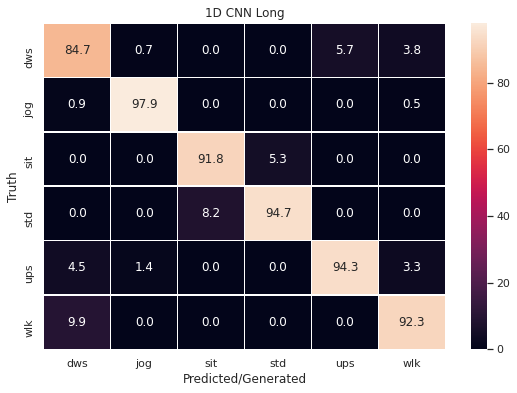

In [388]:
confusion(y_l_pred, Y_l_test, sorted(dataset.ACTIVITIES.values()), "1D CNN Long")

# Saving Models

- KNN { K=1 }
- MLP
- LSTM with 2 LSTM
- 1D CNNs

In [395]:
from joblib import dump
dump(mlp, 'mlp.joblib')
dump(knn_1, 'knn.joblib')

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/joblib/numpy_pickle.py:103: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



['knn.joblib']

In [396]:
cnn_3.save("models/classifiers/cnn_classifier.h5")
cnn_s_3.save("models/classifiers/cnn_s_classifier.h5")
cnn_l_3.save("models/classifiers/cnn_l_classifier.h5")
lstm_2.save("models/classifiers/lstm_classifier.h5")